# [SC57 - Working with big, multi-dimensional geoscientific datasets in Python: a tutorial introduction to xarray](http://meetingorganizer.copernicus.org/EGU2017/session/25651)  
  
  
* Original notebook by [Stephan Hoyer](http://stephanhoyer.com), Rossbypalooza, 2016.  
* Modified by Edward Byers, Matthew Gidden and [Fabien Maussion](http://fabienmaussion.info/) for EGU General Assembly 2017, Vienna, Austria
* Modified by C. Gentemann for GHRSST Science Team Tutorial 2019, Rome, Italy
* Modified by C. Gentemann for OceanHackWeek 2019, Seattle, WA
* PODAACPY file search added by Lewis John McGibbney
  

# With

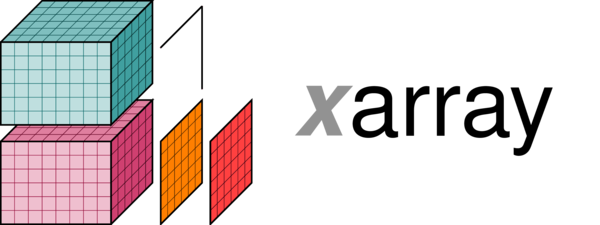

1. you can read netcdf files easily
1. easily intercompare different gridded datasets, even when they are on different grids
1. make timeseries and visualize them

# Structure of this tutorial

1. Searching for data at NASA's PODAAC
1. Opening data
1. Data plotting, exploration, subsetting
1. Comparing two datasets
1. Comparing timeseries of data


# 1. Key features of `xarray`

*  `xarray` is an open source project and Python package
*  `xarray` has been designed to perform **labelled** data analysis on **multi-dimensional** arrays
* the `xarray` approach adopts the Common Data Model for **self-describing scientific data** in widespread use in the Earth sciences
*  `xarray.Dataset` is an in-memory representation of a netCDF file.
* `xarray` is built on top of the dataprocessing library [Pandas](http://pandas.pydata.org) (the best way to work with tabular data (e.g., CSV files) in Python)

# Our data

- numeric
- multi-dimensional
- labelled
- (lots of) metadata
- sometimes (very) large

## What is `xarray` good for?
* Gridded, multi-dimensional and large datasets, commonly used in earth sciences, but also increasingly finance, engineering (signal/image processing), and biological sciences
* Integration with other data analysis packages such as Pandas 
* I/O operations (NetCDF)
* Plotting
* Out of core computation and parallel processing
* ...

# 2. Basic operations in `xarray`

-------------------

## Import python packages

You are going to want numpy, pandas, matplotlib.pyplot, podaaacpy, and xarray

In [1]:
import warnings
warnings.simplefilter('ignore') # filter some warning messages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from pathlib import Path
import configparser
from lxml import objectify

#for search capabilites import podaacpy
import podaac.podaac as podaac
from podaac import drive as podaacdrive

In [2]:
def get_podaac_datasetid(dresult):
    #from @emiliom 
    dresult_xml = objectify.fromstring(dresult)
    # But note that there can be multiple entry instances, so list handling would be needed, generically
    # Actually, the "podaac:datasetId" element would probably be more correct than "id"
    dataset_id = dresult_xml.entry.id.text
    # dataset_shortname = dresult_xml.sho
    return dataset_id

In [3]:
basepath = Path('.')

In [4]:
# then create an instance of the Podaac class
p = podaac.Podaac()

In [5]:
with open(basepath / 'podaac.ini', 'r') as f:
    config = configparser.ConfigParser()
    config.read_file(f)
    d = podaacdrive.Drive(None, 
                          config['drive']['urs_username'], 
                          config['drive']['urs_password'])

## Analysis of winds and SSTs during Hurricane Irene

Irene was a massive storm, with tropical storm force winds extending outward 300 miles (485 km). The storm was also slow moving as it traversed the Mid-Atlantic. Irene claimed at least 48 lives and caused over 7 billion U.S. dollars in damages in the U.S. and 3.1 billion U.S. dollars of damage in the Caribbean. (source: https://www.ncdc.noaa.gov/sotc/tropical-cyclones/201113).

For this tutorial we will use the podaacpy to search for SST and winds during Hurricane Irene and look at the change in upper ocean heat content

In [6]:
dresult = p.dataset_search(keyword='mur',
                           start_time='2011-08-24T00:00:00Z',
                           end_time='2011-09-15T23:59:59Z')
dataset_id = get_podaac_datasetid(dresult)
print(dataset_id)
gresult = p.granule_search(dataset_id=dataset_id,
                           start_time='2011-08-24T00:00:00Z',
                           end_time='2011-09-15T23:59:59Z',
                           items_per_page='400')
# we provide a convenience function which enables easy access to all Drive urls
urls_sst = d.mine_drive_urls_from_granule_search(granule_search_response=gresult)

urls_sst = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') for w in urls_sst]
print('num files:',len(urls_sst))
print(urls_sst)

PODAAC-GHGMR-4FJ04
num files: 23
['https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2011/236/20110824090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2011/237/20110825090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2011/238/20110826090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2011/239/20110827090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2011/240/20110828090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2011/241/20110829090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-

We'll start with the MUR SST dataset. Other tutorial examples [here](https://github.com/pydata/xarray/tree/master/examples).

## 2. Examining your data

* With well designed mdatasets that follow Climate Forecast (CF) conventions, you will usually get coordinates of lat,lon,time which makes it easy to select data and visualize it in different ways.  

* Notice that the time is automatically converted into a np.datetime64 format which can be queried for month, day, etc.  All the variables that are CF compliant are automatically converted (if needed) and read in so that you can immediately start working with the data.  

* Above, you can see that the dimensions are lat, lon, and time

* The coordinates of the datasets are also lat,lon, and time


use [xr.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) to open the provided url and print the dataset

* url is a text string to an online dataset.  When you open a file, you can just use the file name and path or you can just use the url for files that are available online.  If you are running this on the cloud you could even call cloud located data

* Here, we are reading in a global SST dataset called CMC from NASA's PO.DAAC
   

## Open a SST dataset using the filename retrieved by podaacpy
Below, let's open MUR SSTs using xarray and a PODAAC OpenDAP URL.
To open a file use [xr.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)

The url filename we want to use is already included for you.  You can give a local filename or an opendap URL.

Then just print out the file details by just typing the dataset name, ds_sst_mur

## Metadata --- Examining your data


* The data variable (analysed_sst) has the labeled dimensions and metadata attached.  You can see additional metadata (if it exists) by looking at the data variable of interest.  

* Below, type 
```ds_sst_mur.ana``` then hit tab to autocomplete.  
* Then run the cell by holding shift and pressing enter.



## Open & Subset the data using .sel to the North Atlantic region using slice

opening: https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2011/236/20110824090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc <xarray.Dataset>
Dimensions:           (lat: 3001, lon: 6001, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2011-08-24T09:00:00
  * lat               (lat) float32 15.0 15.01 15.02 15.03 ... 44.98 44.99 45.0
  * lon               (lon) float32 -100.0 -99.99 -99.98 ... -40.02 -40.01 -40.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:            

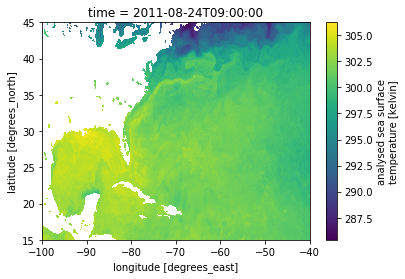

In [7]:
ds_sst = xr.open_dataset(urls_sst[0])
subset_sst = ds_sst.sel(lat=slice(15,45),lon=slice(-100,-40))
print('opening:', urls_sst[0],subset_sst)
subset_sst.analysed_sst.plot()

## Plot the SST.  
### Notice xarray adds labels and title to the plot and colorbar.  

Sometimes the metadata is great and you get exactly the label you need, but sometimes you want to change the label.  Xarray plotting [help](http://xarray.pydata.org/en/stable/plotting.html). A really nice feature of xarray is that it uses the metadata to label the axis.  Let's change the colorbar label by changing the `long_name` attribute

In [8]:
#print out the attributes for `analysed_sst`
print(subset_sst.analysed_sst.attrs)

OrderedDict([('long_name', 'analysed sea surface temperature'), ('standard_name', 'sea_surface_foundation_temperature'), ('units', 'kelvin'), ('valid_min', -32767), ('valid_max', 32767), ('comment', '"Final" version using Multi-Resolution Variational Analysis (MRVA) method for interpolation'), ('source', 'AMSRE-REMSS, AVHRR18_G-NAVO, MODIS_A-JPL, MODIS_T-JPL, iQUAM-NOAA/NESDIS, Ice_Conc-OSISAF')])


In [9]:
#print out the attributes for `analysed_sst`
subset_sst.analysed_sst.attrs['units']='K'
subset_sst.analysed_sst.attrs['long_name']='SST'

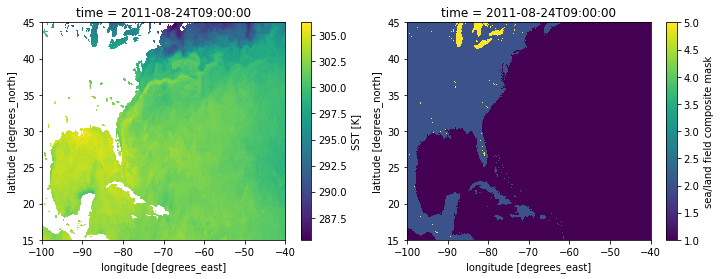

In [10]:
fig, axes = plt.subplots(ncols=2,figsize=[12,4])
subset_sst.analysed_sst.plot(ax=axes[0])
subset_sst.mask.plot(ax=axes[1])

## Mask out land values using .where

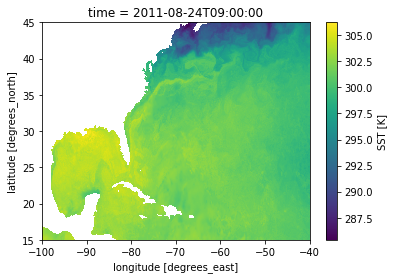

In [11]:
subset_sst_masked = subset_sst.where(subset_sst.mask==1)
subset_sst_masked.analysed_sst.plot()

## Read in CCMP wind data

In [12]:
#if you search for ccmp you get all the different products, easier to look up on podaac website 
# the dataset id for the product you want
dresult = p.dataset_search(keyword='PODAAC-CCF30-01XXX',
                           start_time='2011-08-24T00:00:00Z',
                           end_time='2011-09-15T23:59:59Z')
dataset_id = get_podaac_datasetid(dresult)
print(dataset_id)
gresult = p.granule_search(dataset_id=dataset_id,
                           start_time='2011-08-24T00:00:00Z',
                           end_time='2011-09-15T23:59:59Z',
                           items_per_page='400')
# we provide a convenience function which enables easy access to all Drive urls
urls_wnd = d.mine_drive_urls_from_granule_search(granule_search_response=gresult)

urls_wnd = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') for w in urls_wnd]
print('num files:',len(urls_wnd))
print(urls_wnd)

PODAAC-CCF30-01XXX
num files: 400
['https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/1987/07/analysis_19870702_v11l30flk.nc.gz', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/1987/07/analysis_19870703_v11l30flk.nc.gz', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/1987/07/analysis_19870704_v11l30flk.nc.gz', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/1987/07/analysis_19870705_v11l30flk.nc.gz', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/1987/07/analysis_19870706_v11l30flk.nc.gz', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/1987/07/analysis_19870707_v11l30flk.nc.gz', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/1987/07/analysis_19870708_v11l30flk.nc.gz', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/1987/07/analysis_19870709_v11l30flk.nc.gz', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/1987/07/an

# Calculating the mean using coordinates
* CCMP is a 6-hourly dataset, using .mean to find the daily average and make it easier to compare to daily SSTs
* Here was want to do a daily average, so we will use .mean('time')
* To do a spatial average you would use a dict-like container of coordinates to average over, for example .mean({'lat','lon'})

In [13]:
ds_wnd = xr.open_dataset(urls_wnd[0])
ds_wnd = ds_wnd.mean('time')
print(ds_wnd)

<xarray.Dataset>
Dimensions:  (lat: 628, lon: 1440)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -78.375 -78.125 -77.875 ... 77.875 78.125 78.375
Data variables:
    uwnd     (lat, lon) float32 -2.3934872 -2.3690715 ... 1.9425623 1.9326437
    vwnd     (lat, lon) float32 -6.6318746 -6.6822314 ... -6.2351217 -6.412135
    nobs     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


## Some gridded datasets go from -180 to -180 longitude, others from 0-360.  If you want to compare data, or use many cartopy routines, you will need to know how to switch from one to the other easily.

*  let's change the longitude coordinates using [.coords](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.coords.html) and then [.sortby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sortby.html) |

* this bit of code can be really useful if you open lots of gridded datasets.  I keep it on a post-it note on my desktop.

## To get from 0-360 to -180-180
```
ds.coords['lon'] = np.mod(ds.coords['lon'] + 180,360) - 180  
ds = ds.sortby(ds.lon)
```

## To get from -180-180 to 0-360
```
ds.coords['lon'] = np.mod(ds['lon'], 360)
ds = ds_ccmp.sortby(ds.lon)
```

Change the CCMP datat from 0-360 to -180-180 below and then print out the dataset

In [14]:
ds_wnd.coords['lon'] = np.mod(ds_wnd.coords['lon'] + 180,360) - 180
ds_wnd = ds_wnd.sortby(ds_wnd.lon)
print(ds_wnd.lon)

<xarray.DataArray 'lon' (lon: 1440)>
array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875


## Calculate wind speed and direction from the vectors
* use numpy operators to calculate the square root and arctan2

In [15]:
ds_wnd['wind_speed'] = np.sqrt(ds_wnd.uwnd**2 + ds_wnd.vwnd**2)
ds_wnd['wind_dir'] = np.arctan2(ds_wnd.vwnd,ds_wnd.uwnd)/np.pi*180

## Now that the lon -180 to 180, subset the data same as you did for the SST

In [16]:
subset_wnd = ds_wnd.sel(lat=slice(15,45),lon=slice(-100,-40))
print(subset_wnd)
#subset_wnd.analysed_sst.plot()

<xarray.Dataset>
Dimensions:     (lat: 120, lon: 240)
Coordinates:
  * lon         (lon) float32 -99.875 -99.625 -99.375 ... -40.375 -40.125
  * lat         (lat) float32 15.125 15.375 15.625 ... 44.375 44.625 44.875
Data variables:
    uwnd        (lat, lon) float32 -4.858695 -4.754929 ... 8.357749 8.356986
    vwnd        (lat, lon) float32 1.9799488 2.183666 ... 5.043338 4.9853506
    nobs        (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wind_speed  (lat, lon) float32 5.2466288 5.2323747 ... 9.761518 9.7310295
    wind_dir    (lat, lon) float32 157.8288 155.33339 ... 31.108147 30.818142


## Interpolation and masking data

* To compare the data, apply similar land masks.  
* Since the winds don't include a land mask, use the SST land mask on the wind data, but they aren't on the same grid.  
* Use .interp to put them on the same grid then mask the dataset together


In [17]:
#print out the lat and lon for each dataset
print(subset_sst.lon[0:5].data)
print(subset_wnd.lon[0:5].data)
print(subset_sst.lat[0:5].data)
print(subset_wnd.lat[0:5].data)

[-100.    -99.99  -99.98  -99.97  -99.96]
[-99.875 -99.625 -99.375 -99.125 -98.875]
[15.   15.01 15.02 15.03 15.04]
[15.125 15.375 15.625 15.875 16.125]


## Interpolation and masking

* subset the data, interpolate it onto the ostia grid, then mask it.
* mask ostia 
* show data

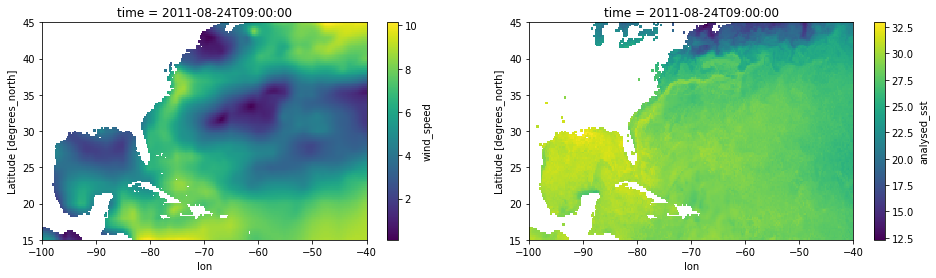

In [18]:
#use interp_like to automatically interpolate the data in time and space, but here only space
#subset_mur_interp = subset_mur.isel(time=0).interp_like(subset_ostia)

# use interp to interpolate the mur data in space onto the ostia grid
subset_sst_interp = subset_sst.interp(lat=subset_wnd.lat,lon=subset_wnd.lon,method='nearest')
# now use the ostia mask on the interpolated mur sst data
subset_wnd_masked = subset_wnd.where(subset_sst_interp.mask==1)

#make a figure showing new datasets
fig, axes = plt.subplots(ncols=2,figsize=[16,4])
subset_wnd_masked.wind_speed.plot(ax=axes[0])
(subset_sst_interp.analysed_sst-273.15).plot(ax=axes[1])


# Histogram and subplots

* Create a figure with two axes using `fig, axes = plt.supplots(ncols=2)`

* To plot on a specific ax you need to set `ax = axes[0]` or `ax = axes[1]` in the hist argument

* Plot the ocean winds histogram on the first axes using [.plot.hist()](http://xarray.pydata.org/en/stable/generated/xarray.plot.hist.html) and the global land/ocean winds on the next

* Change the number of bins using an argument in hist eg.  `bins=20`

* Different [arguments](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist) for .hist  trying making a PDF by using density = True  or change the style of the plot using `histtype = 'step'`


(array([0.00032774, 0.00082926, 0.00157407, 0.00327758, 0.00712671,
        0.01024031, 0.01368912, 0.00970136, 0.01283765, 0.01223631,
        0.011627  , 0.02381872, 0.03186187, 0.10836064, 0.15419958,
        0.27581093, 0.14517251, 0.09515713, 0.04002632, 0.00246115]),
 array([285.386  , 286.42728, 287.4686 , 288.5099 , 289.55118, 290.5925 ,
        291.6338 , 292.67508, 293.7164 , 294.7577 , 295.799  , 296.8403 ,
        297.8816 , 298.9229 , 299.9642 , 301.0055 , 302.0468 , 303.0881 ,
        304.1294 , 305.17072, 306.212  ], dtype=float32),
 <a list of 1 Patch objects>)

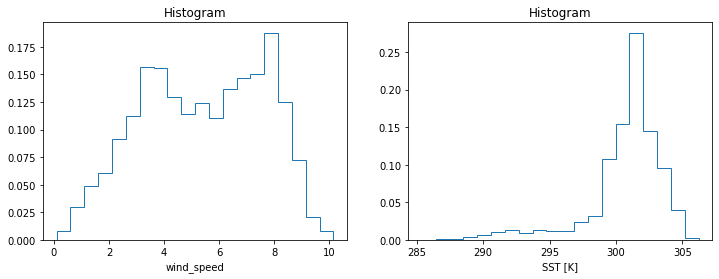

In [19]:
fig, axes = plt.subplots(ncols=2,figsize=[12,4])
subset_wnd_masked.wind_speed.plot.hist(bins=20,ax=axes[0],density = True,histtype='step')
subset_sst.analysed_sst.plot.hist(bins=20,ax=axes[1],density = True,histtype='step')

## Compare time series of the cold wake after Hurricane as measured by MUR and OSTIA SSTs

## When you open a multi-file dataset, xarray uses dask for lasy loading.  
* Lazy loading: It mostly just loads the metadata. You can do data searching, selecting, subsetting without acutally loading the data. 
* Here we have loaded in 30 days of data for two very high resolution SST global datasets.  Before we actually load the data, we are going to want to do some subsetting so that it will fit into our memory.
* Notice below when you print out the dataset details that they are all stored as dask.array types.

In [20]:
ds_sst = xr.open_mfdataset(urls_sst,coords='minimal')
ds_wnd = xr.open_mfdataset(urls_wnd,coords='minimal')

OSError: [Errno -37] NetCDF: Write to read only: b'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/1987/07/analysis_19870705_v11l30flk.nc.gz'

In [ ]:
#shift wnd coordinates, subset, take time mean
ds_wnd.coords['lon'] = np.mod(ds_wnd.coords['lon'] + 180,360) - 180
ds_wnd = ds_wnd.sortby(ds_wnd.lon)

#cal wind speed/dir
ds_wnd['wind_speed'] = np.sqrt(ds_wnd.uwnd**2 + ds_wnd.vwnd**2)
ds_wnd['wind_dir'] = np.arctan2(ds_wnd.vwnd,ds_wnd.uwnd)/np.pi*180

#subset data
subset_sst = ds_sst.sel(lat=slice(15,45),lon=slice(-100,-40))
subset_wnd = ds_wnd.sel(lat=slice(15,45),lon=slice(-100,-40))

subset_sst_interp = subset_sst.interp(lat=subset_wnd.lat,lon=subset_wnd.lon,method='nearest')
# now use the sst mask on the wnd data
subset_wnd_masked = subset_wnd.where(subset_sst_interp.mask==1)


In [ ]:
fig, axes = plt.subplots(ncols=2,figsize=[12,4])
(subset_sst.analysed_sst[-1,:,:]-subset_sst.analysed_sst[0,:,:]).plot(vmin=-1,vmax=1,ax=axes[0])
subset_wnd_masked.wind_speed.max('time').plot(ax=axes[1])

## Where can I find more info?

### For more information about xarray

- Read the [online documentation](http://xarray.pydata.org/)
- Ask questions on [StackOverflow](http://stackoverflow.com/questions/tagged/python-xarray)
- View the source code and file bug reports on [GitHub](http://github.com/pydata/xarray/)

### For more doing data analysis with Python:

- Thomas Wiecki, [A modern guide to getting started with Data Science and Python](http://twiecki.github.io/blog/2014/11/18/python-for-data-science/)
- Wes McKinney, [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) (book)

### Packages building on xarray for the geophysical sciences

For analyzing GCM output:

- [xgcm](https://github.com/xgcm/xgcm) by Ryan Abernathey
- [oogcm](https://github.com/lesommer/oocgcm) by Julien Le Sommer
- [MPAS xarray](https://github.com/pwolfram/mpas_xarray) by Phil Wolfram
- [marc_analysis](https://github.com/darothen/marc_analysis) by Daniel Rothenberg

Other tools:

- [windspharm](https://github.com/ajdawson/windspharm): wind spherical harmonics by Andrew Dawson
- [eofs](https://github.com/ajdawson/eofs): empirical orthogonal functions by Andrew Dawson
- [infinite-diff](https://github.com/spencerahill/infinite-diff) by Spencer Hill 
- [aospy](https://github.com/spencerahill/aospy) by Spencer Hill and Spencer Clark
- [regionmask](https://github.com/mathause/regionmask) by Mathias Hauser
- [salem](https://github.com/fmaussion/salem) by Fabien Maussion

Resources for teaching and learning xarray in geosciences:
- [Fabien's teaching repo](https://github.com/fmaussion/teaching): courses that combine teaching climatology and xarray


In [ ]:
#dresult = p.dataset_search(keyword='ostia',start_time='2018-09-01T00:00:00Z',end_time='2018-09-15T23:59:59Z')
#ccmp
gresult = p.granule_search(dataset_id='PODAAC-GHMWI-4FR05',start_time='2018-09-01T00:00:00Z',end_time='2018-09-30T23:59:59Z')
#ostia
#gresult = p.granule_search(dataset_id='PODAAC-GHOST-4FK02',start_time='2018-09-01T00:00:00Z',end_time='2018-09-30T23:59:59Z')
#use podaac drive to find we provide a convenience function which enables easy access to all Drive urls
urls = d.mine_drive_urls_from_granule_search(granule_search_response=gresult)
urls_ostia = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') for w in urls]
print(urls_ostia)
url = urls_ostia[0] #'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/255/20180912120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc'
ds_sst_ostia = xr.open_dataset(url)
subset_ostia = ds_sst_ostia.sel(lat=slice(15,45),lon=slice(-100,-40))
print(subset_ostia)
subset_ostia.analysed_sst.plot()

In [22]:
print(plt.get_backend())

module://ipykernel.pylab.backend_inline
